##### U-Net architecture

See [here](https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py#L19) for code and [here](https://arxiv.org/pdf/1505.04597.pdf) for the original literature.

In [1]:
# from __future__ import print_function # presumably for compatibility with python 2?

import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Activation, Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D, Cropping2D, BatchNormalization, Dropout
from keras.layers.advanced_activations import LeakyReLU,PReLU
from keras.optimizers import Adam, Adagrad,RMSprop,SGD,Adadelta
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

import pickle
from matplotlib import pyplot as plt

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# from data import load_train_data, load_test_data # These must be custom functions

Using TensorFlow backend.


In [2]:
# Load the components of the pushbullet API

from pushbullet import Pushbullet
with open('../pushbullet.api','r') as f:
    api = f.readline().strip()   
pb = Pushbullet(api)
phone = pb.devices[0]

In [3]:
# Run this cell after anything you want to be notified about!
def push(title='Done!',text='Whatever it was, it\'s done'):
    phone.push_note(title,text)

In [ ]:
# Import the training data

load_whitened = False
if load_whitened:
    with open('./data/x_whitened_resized_array.pickle','rb') as f:
        x = pickle.load(f)
        x = x.astype('float32')
else:
    with open('./data/x_resized_array.pickle','rb') as f:
        x = pickle.load(f)
        x = x.astype('float32')
        # Normalize data to max values
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                x[i,j,:,:] *= 1/x[i,j,:,:].max()
                
with open('./data/y_resized_raster.pickle','rb') as f:
    y = pickle.load(f)
    y = y.astype('float32')

# Just use a single class: roads
#y = y[:,4,:,:]
#y = y[:,np.newaxis,:,:]

# y = y.reshape(y.shape[0],-1)
# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

In [7]:
# Normalize values between 1 and 0
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        #x[i,j,:,:] /= x[i,j,:,:].max()
        x[i,j,:,:] = (x[i,j,:,:].min() - x[i,j,:,:])/(x[i,j,:,:].min() - x[i,j,:,:].max())

In [ ]:
x.min()

In [358]:
def other_jaccard(y_true,y_pred,smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (intersection+smooth) / (np.sum(y_true) + np.sum(y_pred) - intersection+smooth)



for i in range(10):
    print(i,other_jaccard(y[i,np.newaxis,3,np.newaxis,:,:],training_outcomes[i,np.newaxis,:,:]))#np.random.randn(10,10,136,136)))

0 0.01474549356
1 -0.361923034838
2 0.0723116418203
3 0.026622147667
4 0.00710479390005
5 0.0890484711044
6 -0.314118387254
7 0.470643482662
8 0.43338243061
9 0.48507102168


In [379]:
'''
Execute this in order to use a data generator to expand the number of images.
Note: adjust the variables to actually create random images
'''

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

datagen.fit(x[:10,:,:,:])

In [31]:
'''
V2.0 U-Net with batchnorm
'''

def builder(img_rows = x.shape[2],img_cols = x.shape[3],
            nfilters = 32,activation = 'relu',init = 'he_normal',
            lr=1e-5,decay=0.99,momentum=0, nesterov=False):
    
    def dice_coef(y_true, y_pred,smooth = 1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    def jaccard(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

    def jaccard_loss(y_true, y_pred):
        return -jaccard(y_true, y_pred)
    
    def Conv2DReluBatchNorm(n_filter, w_filter, h_filter, inputs, activation='relu',init='he_uniform',dropout=0.2):
        return BatchNormalization(mode=0, axis=1)(Activation(activation=activation)(Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init)(inputs)))
        #return Activation(activation=activation)(Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init)(inputs))

    def up_conv(nfilters,filter_factor,inputs,init=init,activation=activation):
        return Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,activation=activation)(UpSampling2D(size=(2, 2))(inputs))

    inputs = Input((20, img_rows, img_cols))
    padded = ZeroPadding2D(padding=(12,12))(inputs) # was 28,28
    
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, padded, activation=activation,init=init)
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, conv1, activation=activation,init=init)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, pool1, activation=activation,init=init)
    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv2, activation=activation,init=init)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, pool2, activation=activation,init=init)
    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv3, activation=activation,init=init)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, pool3, activation=activation,init=init)
    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv4, activation=activation,init=init)
    pool4 = AveragePooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, pool4, activation=activation,init=init)
    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, conv5, activation=activation,init=init)
        
    #up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    up6 = merge([up_conv(nfilters,8,conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, up6, activation=activation,init=init)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv6, activation=activation,init=init)

    #up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    up7 = merge([up_conv(nfilters,4,conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, up7, activation=activation,init=init)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv7, activation=activation,init=init)

    #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = merge([up_conv(nfilters,2,conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, up8, activation=activation,init=init)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv8, activation=activation,init=init)

    #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = merge([up_conv(nfilters,1,conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, up9, activation=activation,init=init)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, conv9, activation=activation,init=init)

    #conv10 = Conv2DReluBatchNorm(1, 3, 3, conv9, activation='relu',init=init)
    conv10 = Conv2DReluBatchNorm(1, 1, 1, conv9, activation='relu',init=init)

    cropped = Cropping2D(cropping=((12,12), (12,12)))(conv10)
    cropped = Activation(activation='sigmoid')(cropped)
    
    model = Model(input=inputs, output=cropped)
    
    model.compile(optimizer=Adagrad(lr=lr,decay=decay), loss='categorical_crossentropy', metrics=[jaccard])
    
    return model
#builder().summary()

In [73]:
classType = 7
def train_and_predict():
    '''
    lr=1e-5 learned consistently up to 0.1036
    lr=1e-4 bonuces aroun 0.8/0.9 - likely too high. Needs decay?
    lr=1e-4,decay=0.2 learns to 0.1097. Try higher learning rate...
    lr=1e-3 doesn't learn...
    lr=1e-4,decay=0.3 ends at 0.1123
    lr=1e-4,decay=0.4 didn't learn as well but ended at 0.1105 nevertheless. Image didn't look as good.
    lr=1e-4,decay=0.5 learned more slowly. Perhaps increase lr? But the image was better.
    lr=5e-4,decay=0.5 doesn't learn
    lr=1e-4,decay=0.6 learns well, high score 0.1252
    ---Added in the rest of the data---
    lr=1e-4, decay=0.7 is the best maybe? Try with all the data
    lr=1e-4,decay=0.7 doesn't learn with all data :(
    lr=1e-5,decay=0.7 learns very slowly
    lr=1e-5,decay=0.8
    ---Later testing---
    lr=1e-4,decay=0.6 doesn't learn particularly well to 0.1098
    lr=1e-5,decay=0.6 goes to 0.0959
    lr=1e-5,decay=0.6,init=he_uniform goes to 0.1036
    lr=1e-5,decay=0.6,init=glorot_normal goes to 0.0934
    lr=1e-5,decay=0.6,init=glorot_uniform goes to 0.0928 but stops after just 5 epochs, consider increasing patience
    lr=1e-5,decay=0.6,init=glorot_uniform goes to 0.0930 in first epoch and doesn't go further
    ---back to a single image, #5---
    lr=1e-4,decay=0.6 learns to 0.0942
    lr=1e-4,decay=0 learns to 0.0817
    nfilters=16 learns to 0.0501 in 39 epochs but the image is getting better (lr=1e-3,decay=5)
    nfilters=8 learns to 0.0420 in 14 epochs but the image is getting better (lr=1e-3,decay=5)
    ----Keep this one!---
    nfilters=8 learns to 0.2844 in 100 epochs but the image is the best I've ever seen (lr=1e-3,decay=0) using adagrad
    Can achieve similar results with adam optimizer. Note that results differ from run-to-run suggesting init problem
    1000 epochs gets to 0.6247 using adagrad
    ---------------------
    nfilters=8 learns to 0.1069 in 100 (lr=1e-4,decay=0)
    ---Trying with all the data---
    First try goes to 0.1101 which is presumably all-black. Try increasing batch size.
    Doesn't work with batchsize=5 - goes to all zero
    ---Trying with first 10 images---
    lr=1e-3,decay=0,nfilters=2,adagrad
    lr=1e-3,decay=0,he_normal - output had features from the data, but wasn't predictive of roads
    
    ---Another session...---
    Tried LeakyReLU and it seemed to learn better, but bounced around 0.15ish (nfilters=4)
    '''
    
    model = builder(img_rows=x.shape[2],img_cols=x.shape[3],
            nfilters=16,activation='relu',init='he_uniform',
            lr=1e-4,decay=0,momentum=0)
    
    
    print('Fitting model...')
    print('-'*30)
    
    early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=10, verbose=1, mode='min')
    
    model.fit(x[:10,:,:,:], y[:10,classType,np.newaxis,:,:],
              batch_size=10, nb_epoch=100, verbose=1, shuffle=True,
              callbacks=[early_stopping])
    
    '''model.fit_generator(datagen.flow(x[:10,:,:,:], y[:10,classType,np.newaxis,:,:],
                        batch_size=8),
                        samples_per_epoch=32,
                        nb_epoch=100)'''

    print('Predicting masks on test data...')
    print('-'*30)
    
    imgs_mask_test = model.predict(x[:10,:,:,:], verbose=1)
    np.save('jaccard_preds_all_data.npy', imgs_mask_test)
    
    return model

model = train_and_predict()
push('Training is done')

Fitting model...
------------------------------
Epoch 1/100
10/10 [==============================] - 16s - loss: 3.8316 - jaccard: 0.0048
Epoch 2/100
10/10 [==============================] - 7s - loss: 3.7083 - jaccard: 0.0056
Epoch 3/100
10/10 [==============================] - 7s - loss: 3.6263 - jaccard: 0.0062
Epoch 4/100
10/10 [==============================] - 7s - loss: 3.5598 - jaccard: 0.0067
Epoch 5/100
10/10 [==============================] - 7s - loss: 3.5157 - jaccard: 0.0070
Epoch 6/100
10/10 [==============================] - 7s - loss: 3.4749 - jaccard: 0.0073
Epoch 7/100
10/10 [==============================] - 7s - loss: 3.4475 - jaccard: 0.0074
Epoch 8/100
10/10 [==============================] - 7s - loss: 3.4216 - jaccard: 0.0076
Epoch 9/100
10/10 [==============================] - 7s - loss: 3.3991 - jaccard: 0.0077
Epoch 10/100
10/10 [==============================] - 7s - loss: 3.3816 - jaccard: 0.0079
Epoch 11/100
10/10 [==============================] - 7s - l

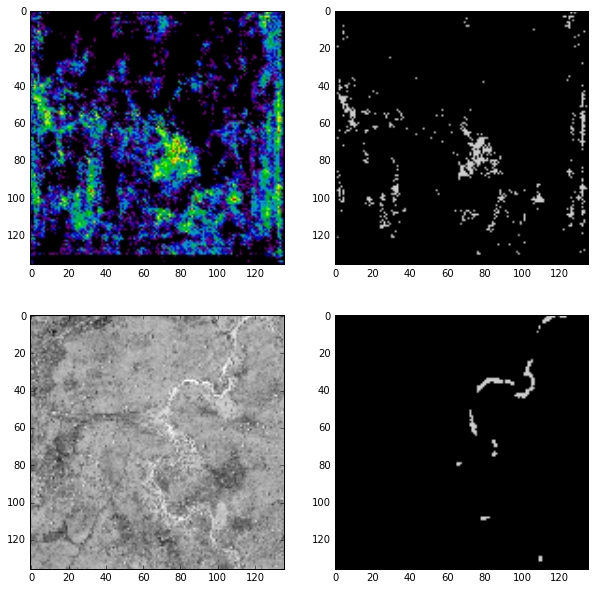

In [74]:
preds = np.load('jaccard_preds_all_data.npy')
norm = True
if norm:
    preds = norm_preds(preds)

plot_all(3,3,classType,0.5)
#push('Images are ready','Go look!')

In [ ]:
# Test the jaccard cost function
other_jaccard(y[:,3,:,:],training_outcomes)

### Helper functions

In [12]:
def norm_preds(preds):
    for i in range(preds.shape[0]):
        preds[i,0,:,:] = (preds[i,0,:,:].min() - preds[i,0,:,:])/(preds[i,0,:,:].min()-preds[i,0,:,:].max())
    return preds

In [13]:
def plot_all(i,j,classType,threshold):
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_subplot(221)
    ax1.imshow(preds[j,0,:,:],cmap='spectral')

    ax2 = fig.add_subplot(222)
    ax2.imshow(preds[j,0,:,:]>threshold,cmap='spectral')

    ax3 = fig.add_subplot(223)
    ax3.imshow(x[i,17,:,:],cmap='Greys')

    ax4 = fig.add_subplot(224)
    ax4.imshow(y[i,classType,:,:],cmap='spectral')
    
#plot_all(2,2,classType,0.5)
#push('PICTURES!','The plots are ready')

### Defunct bits and pieces

### Gridsearch

In [ ]:
# define the grid search parameters
#np.random.randint(low,high,size)
lr = [10 ** np.random.randint(-10,-1)]
decay = np.random.random(10)
params = dict(lr=lr, decay=decay)
classType = 3

'''
KerasClassifier takes model parameters: i.e. arguments of build_fn, 
and fitting parameters, which would have been passed to model.fit()
'''
early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
jaccard = make_scorer(other_jaccard)
model = KerasRegressor(build_fn=builder,
                batch_size=1, nb_epoch=10, verbose=1, shuffle=True,
                nfilters = 4, activation = 'relu', init = 'he_normal', lr=1e-5, decay=0.99)
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_jobs=7,verbose=2,scoring=jaccard)
grid_result = grid.fit(x[5:8,:3,:,:], y[5:8,classType,np.newaxis,:,:])
push('Random search is done','Best score = %f' %grid_result.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Summarize results from gridsearch

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# I don't recall what this is...
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p

In [35]:
'''
Original U-Net without batch norm
'''

def builder(img_rows = x.shape[2],img_cols = x.shape[3],
            nfilters = 32,activation = 'relu',init = 'he_normal',
            lr=1e-5,decay=0.99):
    
    def dice_coef(y_true, y_pred,smooth = 1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    def jaccard(y_true, y_pred,smooth = 1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true * y_pred)
        return (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)

    def jaccard_loss(y_true, y_pred):
        return -jaccard(y_true, y_pred)
    
    
    inputs = Input((20, img_rows, img_cols))
    padded = ZeroPadding2D(padding=(28,28))(inputs)
    
    conv1 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(padded)
    conv1 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(pool1)
    conv2 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(pool2)
    conv3 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(pool3)
    conv4 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(nfilters*16, 3, 3, activation=activation, border_mode='same',init=init)(pool4)
    conv5 = Convolution2D(nfilters*16, 3, 3, activation=activation, border_mode='same',init=init)(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(up6)
    conv6 = Convolution2D(nfilters*8, 3, 3, activation=activation, border_mode='same',init=init)(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(up7)
    conv7 = Convolution2D(nfilters*4, 3, 3, activation=activation, border_mode='same',init=init)(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(up8)
    conv8 = Convolution2D(nfilters*2, 3, 3, activation=activation, border_mode='same',init=init)(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(up9)
    conv9 = Convolution2D(nfilters, 3, 3, activation=activation, border_mode='same',init=init)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid',init=init)(conv9)
    
    cropped = Cropping2D(cropping=((28,28), (28,28)))(conv10)
    model = Model(input=inputs, output=cropped)
    
    model.compile(optimizer=Adagrad(lr=lr,decay=decay), loss=jaccard_loss, metrics=[jaccard])
    
    return model
